# 语义分割 semantic segmentation

- 语意分割将图片中的每个像素分类到对应的类别
    - 语义分割：已知每一个像素的label是什么
    - 属于有监督学习
<img src="./pic/语义分割.PNG" width=400 height=400>
- 属于狗的像素
- 属于猫的像素
- 背景像素
- 语义分割：对每个像素做（label）预测。**转置卷积去预测像素对应的标号**，并不是预测RGB值（所以不是还原）
    - 转置卷积不是上采样，只是要得到pixel level的输出

## 应用：背景虚化

<img src="./pic/背景虚化.PNG" width=400 height=400>

## 应用：路面分割


## vs 实例分割 instance segmentation

- 语义分割只关心像素属于哪个类
- 实例分割：如果一张图里有2只狗，第一只狗的像素属于第一只狗，第二只狗的像素属于第二只狗
<img src="./pic/vs实例分割.PNG" width=400 height=400>

# Pascal VOC2012 语义分割数据集

In [2]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

# d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar', '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
# voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

voc_dir = r"C:\Users\Tyler\Code\data\VOCdevkit\VOC2012"

## 将所有输入的图像和标签读入内存

- voc格式

In [3]:
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB    # RGB格式
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        # 标号与图片大小一样，每个pixel的值对应一个标号
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

## 绘制前5个输入图像及其标签

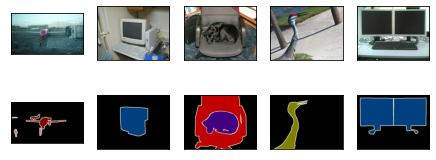

In [4]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]    # 第一行画图片，第二行画标号
imgs = [img.permute(1,2,0) for img in imgs]    # tensor读图片（C，H，W），画图片（H，W，C）
d2l.show_images(imgs, 2, n);
# 不同的颜色表示不同的标号：每一个类，有一个对应RGB的值。值不一样，类别不一样
# 背景是黑色，边界线是白色

# 列举RGB颜色值和类名

In [5]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

# 查找标签中每个像素的类索引

- 把RGB的值换算成标号
- 给定标号换算成RGB值

In [6]:
# colormap 图片
# colormap2label 字典


def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        # 256进制：256二次方，一次方（防止数值重复）
        # 就是RGB每个都是256个数字，用一个数代表RBG的取值需要256**3个数才能完全表示RGB所有颜色
        # 把第i个RGB的值，映射到i（秦九韶算法？）
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label


def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    # 因为一般卷积的输入都是，通道x高x宽，图象是高x宽x通道，这里把卷积输入的格式变成图象格式
    # 拿到label对应的索引
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    
    return colormap2label[idx]

In [7]:
# 以飞机图片为例，0为背景，1为飞机

y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

## 预处理数据

- 使用图像增广中的随机裁剪，裁剪输入图像和标签的相同区域
    - 与图像分类的区别：目标检测和语义分割随机裁剪了图片之后，也要把标号做相应的裁剪。不然像素就无法做到一一对应

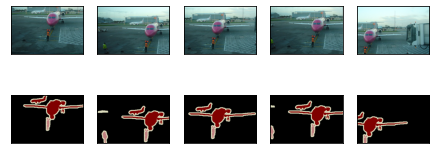

In [8]:
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    # get_params把需要裁剪的边缘框弄出来
    # feature图片
    # (height, width) 高宽
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width)) # 返回一个边缘框
    # 拿到框之后，再做crop，最后把框4个左边放回去（*rect）
    feature = torchvision.transforms.functional.crop(feature, *rect)
    # 对标号做同样的crop
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

# 自定义语义分割数据集类¶

In [9]:
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""

    def __init__(self, is_train, crop_size, voc_dir):
        # 因为voc数据集的图片高宽都不同，为了放入1个batch，所以要用crop统一各图片高宽
        # 不用resize是因为，通过插值拉伸，物体与背景之间的边缘框无法使用label标记。
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # 从ImageNet拿下来的，因为要用ImNet做pretrianed model
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        """假设图片比crop size还要小，去掉小图片和标号"""
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    # 每次返回 可以入batch的样本，做data augmentation
    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

## 读取数据集

In [10]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [11]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True,
                                    num_workers=d2l.get_dataloader_workers())

In [ ]:
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

## 整合所有组件

In [1]:
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter